In [33]:
import numpy as np
import numpy.linalg as npl
import scipy.sparse as spsp
import matplotlib.pyplot as plt

In [34]:
args = [1, 10, 6]
np.linspace(*args)

array([ 1. ,  2.8,  4.6,  6.4,  8.2, 10. ])

In [35]:
def training_set_creator(*args):
    """
    args are a non-zero number of lists of size 3.
    Example of use: we want the creation of an iteratable representing all possible elements on a n-dimensional grid
    first dimension goes from a to b with c elements, then you pass "[a,b,c]" as a first argument.
    return: n-dimensional grid on which you can iterate.
    
    """
    linspace_args = (np.linspace(*arg) for arg in args)
    
    meshes = np.meshgrid(*linspace_args)
    dimensions = map(np.ravel, meshes)
#     dimensions = [mesh.ravel() for mesh in meshes]
    
    tuples = zip(*dimensions)
    return list(tuples)
#     for tup in tuples:
#         yield(tuple(tup))

In [36]:
%%timeit
T0 = np.array([1,50,50])
T1 = np.array([1,5,100])
training_set = training_set_creator(T0,T1)

1.46 ms ± 44.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [37]:
n = 5
N_diff = 2**n
f_diff = np.zeros(N_diff+2)
f_diff[0] = 1

#construction des matrices A en format sparse
tab_A_0 = [np.repeat([1,0],[N_diff//2,N_diff//2+1],0),np.repeat([0,-2,-1,0],[1,N_diff//2-1,1,N_diff//2+1],0),np.repeat([0,1,0],[1,N_diff//2-1,N_diff//2+1],0)]
tab_A_1 = [np.repeat([0,((N_diff+2)**2),0],[N_diff//2,N_diff//2,1],0),np.repeat([1,0,-((N_diff+2)**2),-2*((N_diff+2)**2),1],[1,N_diff//2-1,1,N_diff//2,1],0),np.repeat([0,((N_diff+2)**2)],[N_diff//2,N_diff//2+1],0)]
A_0 = spsp.diags(tab_A_0,[-1,0,1],(N_diff+2,N_diff+2))*((N_diff+2)**2)
A_1 = spsp.diags(tab_A_1,[-1,0,1],(N_diff+2,N_diff+2))


In [38]:
def apply_mu(mu):
    """
    from output of pre_computer and a mu: computes A_rb and f_rb and u_rb, the solution of A_rb.u_rb=f_rb
    """
    A = A_1.todense()
    A += A_0.todense() * mu[0]
    
    f = f_diff * mu[1]      
        
    return [A, f]

def to_array_A_and_f(MUs):
    A = []
    f = []
    
    for mu in MUs:
        temp = apply_mu(mu)
        A.append(temp[0])
        f.append(temp[1])
        
    return np.array(A), np.array(f)

In [39]:
def greedy_algorithm(tol, MUs):
    # On prend un mu (au hasard) pour initialiser l'algorithme
    mu_1 = MUs[0]
    A_delta_mu, f_delta_mu = apply_mu(mu_1)
#     print(A_delta_mu, f_delta_mu)
    u_delta_mu_1 = npl.solve(A_delta_mu, f_delta_mu)
    np.delete(MUs, 0)
    
    # B est la matrice de changement de base de A_delta à A_rb
    B = np.copy(u_delta_mu_1)
    
    # A @ u = f pour un mu donné
    
    # TODO: Repenser précomputing de A_DELTA et F_DELTA pour diminuer coûts mémoire
    A_DELTA, F_DELTA = to_array_A_and_f(MUs)    
    
    # On calcule tous les u_delta pour éviter de le refair dans la boucle par la suite
    U_DELTA = np.array([npl.solve(A_DELTA[idx], F_DELTA[idx]) for idx in range(len(MUs))])
    
    print("Offline phase done")
    
    err = 1e10
    
    n = 1
    
    while err > tol and len(MUs) > 0:
        print(f"Itération n°{n}")
        print("Erreur:", err)
        
        eta = np.zeros(len(MUs))
        
        for idx_mu, mu in enumerate(MUs):
            A_delta_mu = A_DELTA[idx_mu]
            f_delta_mu = F_DELTA[idx_mu]
        
            u_delta_mu = U_DELTA[idx_mu]
            
            # A_rb_mu @ u_rb_mu = f_rb_mu
            # A_rb_mu = B.T @ A_delta_mu @ B
        
            try:
                u_rb_mu = npl.solve(B @ A_delta_mu @ B.T, B @ f_delta_mu)
                
            except npl.LinAlgError:
#                 if n == 3:
#                     print(B.shape, A_delta_mu.shape, f_delta_mu.shape)
#                     return B, A_delta_mu, f_delta_mu
                u_rb_mu = npl.solve(B[np.newaxis, :] @ A_delta_mu @ B[np.newaxis, :].T, 
                                    B[np.newaxis, :] @ f_delta_mu)
            
            except ValueError:
                return B, A_delta_mu, f_delta_mu
            
            
            # Pour l'instant, eta(mu) = ||u_delta - u_rb||_L2
            try:
                eta[idx_mu] = npl.norm(u_delta_mu - u_rb_mu, ord=2)
            except ValueError:
                streched_u_rb_mu = B.T @ u_rb_mu
                eta[idx_mu] = npl.norm(u_delta_mu - streched_u_rb_mu, ord=2)
        
        # On cherche la pire approximation
        idx_worst_mu = np.argmax(eta)
        
        B = np.vstack((B, U_DELTA[idx_worst_mu]))
        print("Mu choisi et son index dans la liste:", MUs[idx_worst_mu], idx_worst_mu)
#         np.delete(MUs, idx_worst_mu)
        MUs.pop(idx_worst_mu)
        np.delete(U_DELTA, idx_worst_mu)
        err = eta[idx_worst_mu]
        n += 1
        
    print("Erreur:", err)
    return B, err

In [40]:
### computes greedy_base
T0 = np.array([1,50,50])
T1 = np.array([1,5,100])
training_set = training_set_creator(T0,T1)
Base, error = greedy_algorithm(0.0001, training_set)
# B, A, f = greedy_algorithm(0.0001, training_set)
# u_delta, u_rb = greedy_algorithm(0.0001, training_set)

Offline phase done
Itération n°1
Erreur: 10000000000.0
Mu choisi et son index dans la liste: (50.0, 5.0) 4999
Itération n°2
Erreur: 23.248181187922434
Mu choisi et son index dans la liste: (48.0, 5.0) 4997
Erreur: 1.857221148076631e-09


In [41]:
Base

array([[1.        , 0.96969697, 0.93939394, 0.90909091, 0.87878788,
        0.84848485, 0.81818182, 0.78787879, 0.75757576, 0.72727273,
        0.6969697 , 0.66666667, 0.63636364, 0.60606061, 0.57575758,
        0.54545455, 0.51515152, 0.48484848, 0.45454545, 0.42424242,
        0.39393939, 0.36363636, 0.33333333, 0.3030303 , 0.27272727,
        0.24242424, 0.21212121, 0.18181818, 0.15151515, 0.12121212,
        0.09090909, 0.06060606, 0.03030303, 0.        ],
       [5.        , 4.99422633, 4.98845266, 4.98267898, 4.97690531,
        4.97113164, 4.96535797, 4.9595843 , 4.95381062, 4.94803695,
        4.94226328, 4.93648961, 4.93071594, 4.92494226, 4.91916859,
        4.91339492, 4.90762125, 4.61893764, 4.33025404, 4.04157044,
        3.75288684, 3.46420323, 3.17551963, 2.88683603, 2.59815242,
        2.30946882, 2.02078522, 1.73210162, 1.44341801, 1.15473441,
        0.86605081, 0.57736721, 0.2886836 , 0.        ],
       [5.        , 4.99399038, 4.98798077, 4.98197115, 4.97596154,
  

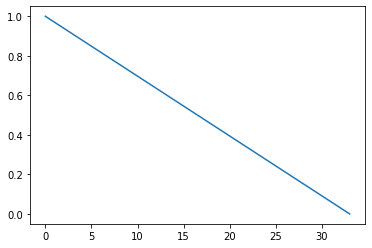

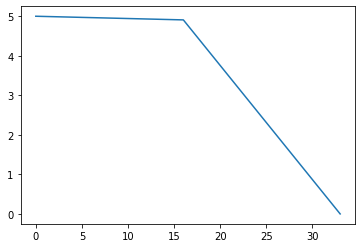

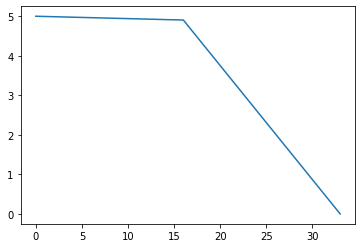

In [14]:
for b in Base:
    plt.plot(b)
    plt.show()

In [42]:
### From Base, fast evaluates u_rb(mu_test)
mu_test = (0.28,40)
U_rb = reduced_solver(mu_test,A_q,shape)
X,U_true = solver(mu_test,plot = True)
plt.plot(X,U_true,label="true_sol")
plt.plot(X,Base.dot(U_rb),label="reduced_sol")
plt.legend()
plt.show()
print(np.sum(np.abs(U_true-Base.dot(U_rb))))

NameError: name 'reduced_solver' is not defined

In [53]:
apply_mu([2.5, 0.5])[1].shape

(34,)

In [18]:
B.shape, A.shape, f.shape

((2, 34), (34, 34), (34,))

In [72]:
B[:,np.newaxis].shape

(34, 1)

In [71]:
B.shape

(34,)

In [19]:
A_rb = B @ A @ B.T

In [21]:
A_rb.shape

(2, 2)

In [33]:
np.interp(x=np.arange(u_delta.size), xp=np.arange(u_rb.size), fp=u_rb)

array([ 1.0000000e+00, -2.5669354e-16, -2.5669354e-16, -2.5669354e-16,
       -2.5669354e-16, -2.5669354e-16, -2.5669354e-16, -2.5669354e-16,
       -2.5669354e-16, -2.5669354e-16, -2.5669354e-16, -2.5669354e-16,
       -2.5669354e-16, -2.5669354e-16, -2.5669354e-16, -2.5669354e-16,
       -2.5669354e-16, -2.5669354e-16, -2.5669354e-16, -2.5669354e-16,
       -2.5669354e-16, -2.5669354e-16, -2.5669354e-16, -2.5669354e-16,
       -2.5669354e-16, -2.5669354e-16, -2.5669354e-16, -2.5669354e-16,
       -2.5669354e-16, -2.5669354e-16, -2.5669354e-16, -2.5669354e-16,
       -2.5669354e-16, -2.5669354e-16])

In [49]:
p = interpolate(u_rb, u_delta.size)

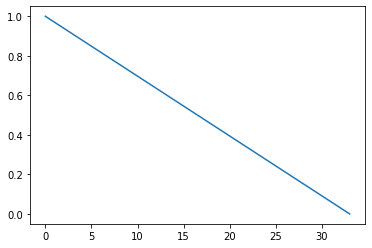

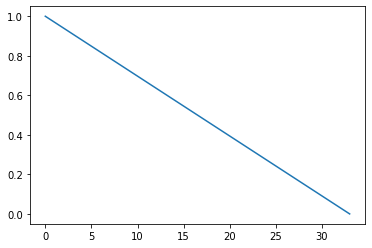

In [51]:
plt.figure()
plt.plot(u_delta)
plt.show()
plt.figure()
plt.plot(p)
plt.show()